## Visualising Different Types of Solutions

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)G = # Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import argparse
import json
import time
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
import mlflow
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pylab

# Custom Libraries
import qaoa_vrp.build_graph
import qaoa_vrp.features.graph_features
import qaoa_vrp.features.tsp_features
import qaoa_vrp.build_circuit
import qaoa_vrp.clustering
import qaoa_vrp.utils
from qaoa_vrp.exp_utils import str2bool, make_temp_directory
from qaoa_vrp.quantum_burden import compute_quantum_burden
from qaoa_vrp.classical.greedy_tsp import greedy_tsp
from qaoa_vrp.plot.draw_euclidean_graphs import draw_euclidean_graph
from qaoa_vrp.parallel.optimize_qaoa import run_qaoa_parallel

# QISKIT stuff
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver,VQE
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, NELDER_MEAD, SPSA
from qiskit.circuit import Parameter
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo
from qiskit.optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
)
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import max_cut, tsp

# import logging
# logging.basicConfig(level=logging.INFO)
# logging.getLogger('qiskit.algorithms.minimum_eigen_solvers.vqe').setLevel(logging.INFO)

/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/finance/__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')
/Users/vivekkatial/.local/share/virtualenvs/HAQC-azaY3fAi/lib/python3.9/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimizati

In [2]:
filename="instanceType_euclidean_tsp_numNodes_4_numVehicles_1_87a170c748e240d0b71d5fb7fe7de707.json"
instance_path = "../data/{}".format(filename)
with open(instance_path) as f:
        data = json.load(f)

In [3]:
# Build Graph
G, depot_info = qaoa_vrp.build_graph.build_json_graph(data["graph"])
num_vehicles = int(data["numVehicles"])
threshold = float(data["threshold"])
n_max = int(data["n_max"])
instance_type = data["instance_type"]
p_max = data["p_max"]
depot_edges = list(G.edges(depot_info["id"], data=True))
depot_node = depot_info["id"]
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))
for edge in G.edges():
    G[edge[0]][edge[1]]['cost'] = 0
edge_mat = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
cost_mat = np.array(nx.attr_matrix(G, edge_attr="cost", rc_order=list(G.nodes())))

In [4]:
G, cluster_mapping = qaoa_vrp.clustering.create_clusters(
    G, num_vehicles, "spectral-clustering", edge_mat
)

subgraphs = qaoa_vrp.clustering.build_sub_graphs(G, depot_node, depot_edges)

# big_offset = sum(sum(cost_mat))/2 + 1
big_offset=30
qubos = qaoa_vrp.build_circuit.build_qubos(subgraphs, depot_info,A=big_offset)
cluster_mapping = [i + 1 for i in cluster_mapping]
cluster_mapping.insert(0, 0)

In [5]:
qubo = qubos[0]
qubo

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 120 X11 - 120 X12 - 120 X13 - 120 X21 - 120 X22 - 120 X23 - 120 X31
      - 120 X32 - 120 X33 + [ 120 X11^2 + 120 X11*X12 + 120 X11*X13
      + 120 X11*X21 + 120 X11*X31 + 120 X12^2 + 120 X12*X13 + 120 X12*X22
      + 120 X12*X32 + 120 X13^2 + 120 X13*X23 + 120 X13*X33 + 120 X21^2
      + 120 X21*X22 + 120 X21*X23 + 120 X21*X31 + 120 X22^2 + 120 X22*X23
      + 120 X22*X32 + 120 X23^2 + 120 X23*X33 + 120 X31^2 + 120 X31*X32
      + 120 X31*X33 + 120 X32^2 + 120 X32*X33 + 120 X33^2 ]/2 + 180
Subject To

Bounds
 0 <= X11 <= 1
 0 <= X12 <= 1
 0 <= X13 <= 1
 0 <= X21 <= 1
 0 <= X22 <= 1
 0 <= X23 <= 1
 0 <= X31 <= 1
 0 <= X32 <= 1
 0 <= X33 <= 1

Binaries
 X11 X12 X13 X21 X22 X23 X31 X32 X33
End

In [6]:
single_qubo_solution_data = {}
single_qubo_solution_data["qubo_id"] = 0
single_qubo_solution_data["cluster"] = [
    index
    for index, node in enumerate(cluster_mapping)
    if node == 1 or node == 0
]
num_nodes=len(single_qubo_solution_data['cluster'])
num_nodes

5

In [7]:
op, offset = qubo.to_ising()
num_qubits = qubo.get_num_vars()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(op.print_details())

Offset: 180.0
Ising Hamiltonian:
IIIIIIIIZ	(-30+0j)
IIIIIIIZI	(-30+0j)
IIIIIIZII	(-30+0j)
IIIIIZIII	(-30+0j)
IIIIZIIII	(-30+0j)
IIIZIIIII	(-30+0j)
IIZIIIIII	(-30+0j)
IZIIIIIII	(-30+0j)
ZIIIIIIII	(-30+0j)
IIIIIIIZZ	(15+0j)
IIIIIIZIZ	(15+0j)
IIIIIIZZI	(15+0j)
IIIIIZIIZ	(15+0j)
IIIIZIIZI	(15+0j)
IIIIZZIII	(15+0j)
IIIZIIZII	(15+0j)
IIIZIZIII	(15+0j)
IIIZZIIII	(15+0j)
IIZIIIIIZ	(15+0j)
IIZIIZIII	(15+0j)
IZIIIIIZI	(15+0j)
IZIIZIIII	(15+0j)
IZZIIIIII	(15+0j)
ZIIIIIZII	(15+0j)
ZIIZIIIII	(15+0j)
ZIZIIIIII	(15+0j)
ZZIIIIIII	(15+0j)



In [8]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;

minimize
 - 60 x_0 - 60 x_1 - 60 x_2 - 60 x_3 - 60 x_4 - 60 x_5 - 60 x_6 - 60 x_7
 - 60 x_8 [ 60 x_0*x_1 + 60 x_0*x_2 + 60 x_0*x_3 + 60 x_0*x_6 + 60 x_1*x_2
 + 60 x_1*x_4 + 60 x_1*x_7 + 60 x_2*x_5 + 60 x_2*x_8 + 60 x_3*x_4 + 60 x_3*x_5
 + 60 x_3*x_6 + 60 x_4*x_5 + 60 x_4*x_7 + 60 x_5*x_8 + 60 x_6*x_7 + 60 x_6*x_8
 + 60 x_7*x_8 ] + 180;
 
subject to {

}


In [9]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact.solve(qp)
print(exact_result)

optimal function value: 0.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
status: SUCCESS


In [10]:
ee = NumPyMinimumEigensolver(op)
exact_result = ee.run()

In [11]:
print('energy:', exact_result.eigenvalue.real)
print('tsp objective:', exact_result.eigenvalue.real + offset)
x = sample_most_likely(exact_result.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, cost_mat))

energy: -180.0
tsp objective: 0.0
feasible: True
solution: [1, 2, 0]
solution objective: 0.0


In [41]:
budget=100
optimizers = [
    COBYLA(maxiter=budget, disp=True, rhobeg=0.1),
]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
for pauli in op:
    print(pauli)

-30.0 * IIIIIIIIZ
-30.0 * IIIIIIIZI
-30.0 * IIIIIIZII
-30.0 * IIIIIZIII
-30.0 * IIIIZIIII
-30.0 * IIIZIIIII
-30.0 * IIZIIIIII
-30.0 * IZIIIIIII
-30.0 * ZIIIIIIII
15.0 * IIIIIIIZZ
15.0 * IIIIIIZIZ
15.0 * IIIIIIZZI
15.0 * IIIIIZIIZ
15.0 * IIIIZIIZI
15.0 * IIIIZZIII
15.0 * IIIZIIZII
15.0 * IIIZIZIII
15.0 * IIIZZIIII
15.0 * IIZIIIIIZ
15.0 * IIZIIZIII
15.0 * IZIIIIIZI
15.0 * IZIIZIIII
15.0 * IZZIIIIII
15.0 * ZIIIIIZII
15.0 * ZIIZIIIII
15.0 * ZIZIIIIII
15.0 * ZZIIIIIII


In [44]:
result = run_qaoa_parallel(args=[
                NELDER_MEAD(maxfev=budget, disp=True, adaptive=True, tol=0.1),
                2500,
                op,
                5,
                False,
            ])

 Running Optimizer: NELDER_MEAD in parallel
 Ending run for  Optimizer: NELDER_MEAD in parallel


## Construct Functions for investigating feasibility

We first build a function `conver_bitstr_to_state` which takes a `str` representation of a state e.g. `100010001` and represents it as a `numpy.Array`.

Then we implement a `check_constraint` function. This validates whether time and/or city constraints are validated.

In [21]:
def conver_bitstr_to_state(bitstr):
    return np.array([float(i) for i in bitstr])

In [22]:
def check_constraint(state_vec, cns_type="city"):
    if cns_type not in ["city", "time"]:
        raise ValueError("Can only handle 'city' or 'time' constraints")
    state_vec = conver_bitstr_to_state(state_vec)
    # Find num nodes
    dim = int(np.sqrt(len(state_vec)))
    # Matrix Representation
    matrix_rep = state_vec.reshape(dim, dim)    
    # All row sums must equal to 1. for time constraints    
    time_sum = np.sum(matrix_rep, axis=1)
    # All column sums must equal to 1. for city constraints
    city_sum = np.sum(matrix_rep, axis=0)
    
    if cns_type=="city":
        return np.array_equal(city_sum, np.ones(dim))
    else:
        return np.array_equal(time_sum, np.ones(dim))

Let's try some feasible and infeasible solutions to assert that are function is actually working for different states

In [23]:
# Test it works for feasible solution
test_state='010100001'
expected_city_cns=True
expected_time_cns=True
assert expected_city_cns==check_constraint(test_state, 'city')
assert expected_time_cns==check_constraint(test_state, 'time')

# Test it works for a invalid city constraint BUT valid time constraint
test_state='010001001'
expected_city_cns=False
expected_time_cns=True
assert expected_city_cns==check_constraint(test_state, 'city')
assert expected_time_cns==check_constraint(test_state, 'time')

# Test it works for a invalid time constraint BUT valid city constraint
test_state='111000000'
expected_city_cns=True
expected_time_cns=False
assert expected_city_cns==check_constraint(test_state, 'city')
assert expected_time_cns==check_constraint(test_state, 'time')

# Test it works for both invalid time constraint AND valid city constraint
test_state='000000000'
expected_city_cns=False
expected_time_cns=False
assert expected_city_cns==check_constraint(test_state, 'city')
assert expected_time_cns==check_constraint(test_state, 'time')

Now its working; fantastic let's look at our results as we break them down by the type of constraints being violated

In [24]:
def generate_feasibility_results(eigenstate, exact_result):
    """Plotting function for a graph of feasibility

    Args:
        eigenstate (np.Array): [description]
        exact_result (np.Array): [description]
    """
    feasible_count =0
    infeasible_count=0
    solution_count=0
    vio_city_cnts=0
    vio_time_cnts=0
    vio_both_cnts=0
    
    feasibility_results = {
        "feasible_count": None,
        "infeasible_count": None,
        "vio_city_cnts": None,
        "vio_time_cnts": None,
        "vio_both_cnts": None,
        "solution_count": None,
        "random_guess": None,
    }

    num_feasible = len([x for x in eigenstate.keys() if tsp.tsp_feasible(x)])
    x = sample_most_likely(exact_result.eigenstate)
    exact_sol_state = ''.join([str(i) for i in x])
    for state in eigenstate.keys():
        if check_constraint(state, cns_type="city") and check_constraint(state, cns_type="time") and tsp.tsp_feasible(state):
            feasible_count += eigenstate[state]
        if check_constraint(state, cns_type="time") and not check_constraint(state, cns_type="city"):
            vio_city_cnts += eigenstate[state]
            infeasible_count += eigenstate[state]
        if check_constraint(state, cns_type="city") and not check_constraint(state, cns_type="time"):
            vio_time_cnts += eigenstate[state]
            infeasible_count += eigenstate[state]
        if not check_constraint(state, cns_type="city") and not check_constraint(state, cns_type="time"):
            vio_both_cnts += eigenstate[state]
            infeasible_count += eigenstate[state]
        if exact_sol_state == state:
            solution_count = eigenstate[state]
            

    feasibility_results["feasible_count"] = feasible_count
    feasibility_results["infeasible_count"] = infeasible_count
    feasibility_results["solution_count"] = solution_count
    feasibility_results["vio_city_cnts"] = vio_city_cnts
    feasibility_results["vio_time_cnts"] = vio_time_cnts
    feasibility_results["vio_both_cnts"] = vio_both_cnts
    feasibility_results["random_guess"] = (
        feasible_count + infeasible_count
    ) / 2**len(state)
    feasibility_results["random_feasible_guess"] = (
        feasible_count + infeasible_count
    ) / num_feasible
    
    return feasibility_results
    
def plot_feasibility_results(feasibility_results):
    keys = list(feasibility_results.keys())
    # # get values in the same order as keys, and parse percentage values
    vals = [feasibility_results[k] for k in keys]
    
    sns.set_color_codes("muted")
    feasible_plot = sns.barplot(x=keys, y=vals)
    feasible_plot.set_xticklabels(
        feasible_plot.get_xticklabels(), rotation=90, horizontalalignment='right'
    )

    return feasible_plot


<AxesSubplot:>

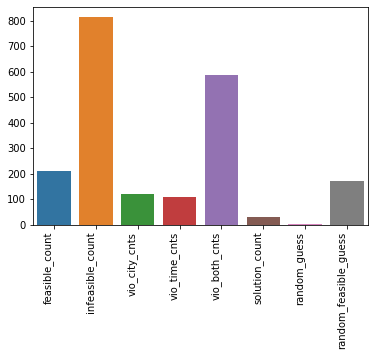

In [25]:
feasibility_results = generate_feasibility_results(result['min_energy_state'], exact_result)
feasibility_results
plot_feasibility_results(feasibility_results)

In [34]:
print('solution objective:', tsp.tsp_value(z, cost_mat))

solution objective: 0.0


In [36]:
total=0 
for key in result['min_energy_state'].keys():
    total+= result['min_energy_state'][key]
    
total

1024

In [39]:
feasibility_results

{'feasible_count': 211,
 'infeasible_count': 813,
 'vio_city_cnts': 120,
 'vio_time_cnts': 107,
 'vio_both_cnts': 586,
 'solution_count': 31,
 'random_guess': 2.0,
 'random_feasible_guess': 170.66666666666666}

In [40]:
211+813

1024